#Prediction based on Linear SVM with average at sample level

In [89]:
import pickle
import scipy
import scipy.io
import os
import numpy as np
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import scanpy as sc
import sklearn.model_selection as sks
import numpy as np
import pandas as pd
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import sklearn.metrics as skm
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
import matplotlib.colors as clr
from matplotlib.ticker import MaxNLocator
import random
import collections


We use cohort 2 as a training set and cohort1 as test set and we use top marker genes as features 

# Load cohort1 and cohort2

In [90]:
with open("../../2cohorts/chr2chr1/Xtest__.pkl", "rb") as f:
                Xtest = pickle.load(f)
with open("../../2cohorts/chr2chr1/Xall.pkl", "rb") as f:
                Xall = pickle.load(f)
with open("../../2cohorts/chr2chr1/Ctest__.pkl", "rb") as f:
                adata1_c = pickle.load(f)
with open("../../2cohorts/chr2chr1/Call__.pkl", "rb") as f:
                adata_c = pickle.load(f)
                

## Load marker genes obtanined using seurat code

In [135]:
df= pd.read_csv('../scripts/marker_cohort2')
df["avg_log2FC"] = np.abs(df["avg_log2FC"])
feat_tab = df.groupby('cluster')
df2= feat_tab.apply(lambda x: x.sort_values(["avg_log2FC"], ascending=False)).reset_index(drop=True)
feat=df2.groupby('cluster').head(20)     

In [136]:
markers=feat.gene.values

In [137]:
markers

array(['IL7R', 'TCF7', 'LTB', 'MAL', 'LEF1', 'RCAN3', 'TRAC', 'LDHB',
       'TRBC2', 'CCR7', 'CD3E', 'AC245427.1', 'RPS12', 'DGKA', 'PIM2',
       'BCL11B', 'TRABD2A', 'PCED1B-AS1', 'ETS1', 'AQP3', 'MAFB', 'RGCC',
       'C5AR1', 'CXCL8', 'DUSP6', 'PLAUR', 'CD14', 'FCN1', 'LYZ',
       'S100A9', 'VCAN', 'IL1B', 'G0S2', 'SGK1', 'KLF4', 'FOS', 'PSAP',
       'CLEC7A', 'FTH1', 'PLBD1', 'CCL5', 'CD8A', 'GZMH', 'NKG7', 'TRGC2',
       'GZMA', 'IL32', 'CST7', 'DUSP2', 'CD8B', 'CD3G', 'GZMK', 'FGFBP2',
       'KLRG1', 'CD2', 'RUNX3', 'TRAC', 'CD3D', 'CD3E', 'ARL4C', 'GNLY',
       'PRF1', 'FGFBP2', 'SPON2', 'NKG7', 'GZMB', 'IL2RB', 'KLRF1',
       'CTSW', 'KLRD1', 'CST7', 'GZMA', 'CCL4', 'CCL5', 'RUNX3', 'SH2D1B',
       'KLRB1', 'CD7', 'CX3CR1', 'FCGR3A', 'IFI27', 'IFI6', 'IFITM3',
       'CLU', 'RNASE2', 'CD163', 'FCER1G', 'ISG15', 'SIGLEC1', 'APOBEC3A',
       'MS4A4A', 'S100A9', 'FTL', 'PLBD1', 'SPI1', 'PSAP', 'MX1', 'CTSB',
       'SELL', 'CCR1', 'MS4A1', 'CD79A', 'IGHM', 'IGHD', 'BANK1

### Markers from the published paper

In [138]:
# markers = ['HLA-DRA','HLA-DRB1','LYZ','CST3','TYROBP','AP1S2','CSTA','FCN1','MS4A6A','LST1','CYBB','CTSS','DUSP6','IL1B','SGK1','KLF4','CLEC7A','ATP2B1-AS1','MARCKS',
# 'SAT1','MYADM','IFI27','IFITM3','ISG15','APOBEC3A','IFI6','TNFSF10','MT2A','MX1','IFIT3','MNDA','S100A12','S100A9','S100A8','MAFB','VCAN','PLBD1','CXCL8',
# 'RNASE2','FCGR3A','MS4A7','CDKN1C','AIF1','COTL1','FCER1G','C1QA','RHOC','FCGR3B','IFITM2','NAMPT','G0S2','PROK2','CMTM2',
# 'BASP1','BCL2A1','SLC25A37','DEFA3','LTF','LCN2','CAMP','RETN','DEFA4','CD24','PGLYRP1','OLFM4']

In [139]:
idx_te= np.where(adata1_c.isin (markers))[0]
idx_tr= np.where(adata_c.isin (adata1_c[idx_te]))[0]
len(idx_tr)

255

# Input formating for the prediction 

In [162]:
gm = collections.defaultdict(list)
count_train = collections.defaultdict(int)
count_test = collections.defaultdict(int)
count_train_s = []
count_test_s = []

for XX in Xall:
    random.shuffle(XX)
    Xtrain = list(map(lambda x: (x[0].todense(), *x[1:]), XX))
    Xtrain = list(map(lambda x: (x[0][:,idx_tr], *x[1:]), Xtrain))
    print(len(Xtrain))
    nb = int(len(Xtrain)*0.75)
    print(nb)
    nb_ = int(len(Xtrain)*0.25)
    print(nb_)
    print()
    for i in range(nb+1):
        X, y, *_ = Xtrain[i]
        gm['train'].append(X)
        count_train[y] += 1
        count_train_s.append(X.shape[0])
    for i in range(nb_):
        X, y, *_ = Xtrain[nb+1+i]
        gm['test'].append(X)
        count_test[y] += 1   
        count_test_s.append(X.shape[0])
for state in gm:
        gm[state] = np.concatenate(gm[state])
        print(gm[state].shape)

25
18
6

25
18
6

(29120, 255)
(9579, 255)


In [163]:
29120+9579

38699

# SVM

In [ ]:
# c_values = [1.0,  2.0]
# class_weight = ['balanced']
# loss = ['hinge']
# hyperparam_grid = dict(C=c_values,loss= loss, class_weight= class_weight)
# s = svm.LinearSVC(random_state=42)
c_values = [1.0,  2.0]
kernel_values = [ 'linear' , 'rbf' ]
class_weight = [ None]
hyperparam_grid = dict(C=c_values, kernel=kernel_values, class_weight= class_weight)
s = svm.SVC(random_state=42,  probability=True)
clf = sks.GridSearchCV(s,hyperparam_grid,scoring='f1',cv=5, refit=True)
a= np.zeros(sum(count_train_s[:count_train[0]]))
y_train=np.append(a,np.ones(sum(count_train_s[count_train[0]:])) )
grid_result = clf.fit(gm['train'], y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


### prediction on 25% of cohort2

In [165]:
pred=clf.decision_function(gm['test'])
a= np.zeros(sum(count_test_s[:count_test[0]]))
y_true=np.append(a,np.ones(sum(count_test_s[count_test[0]:])) )

### Extract prediction at sample level

In [166]:
pred_agg=[]
y_t=[]
a= np.zeros(sum(count_test_s[:count_test[0]]))
for ii in range(len(count_test_s)):
    if ii ==0:
        pred_agg.append(np.mean(pred[:count_test_s[ii]]))
        y_t.append(np.mean(y_true[:count_test_s[ii]]))

    else:
        iiii=ii-1
        iii = sum(count_test_s[:ii])
        pred_agg.append(np.mean(pred[iii:iii+count_test_s[ii]]))
        y_t.append(np.mean(y_true[iii:iii+count_test_s[ii]]))


### AUC

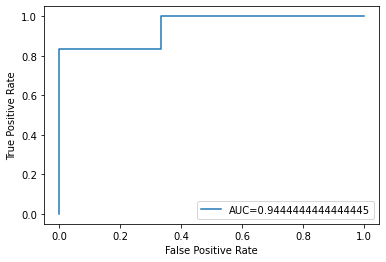

In [167]:
    classes_=[0,1]
    fpr, tpr, _ = skm.roc_curve(y_t,  pred_agg)
    auc = skm.roc_auc_score(y_t,  pred_agg)

    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print(auc)

# Test on Cohort1

In [168]:
XX = list(map(lambda x: (x[0].todense(), *x[1:]), Xtest))
gm2 = collections.defaultdict(list)
count_test2 = collections.defaultdict(int)
count_test2_s = []
Xtest_ = list(map(lambda x: (x[0][:,idx_te], *x[1:]), XX))
print(len(Xtest_))
for X, y, *_ in Xtest_:
        gm2['test'].append(X)
        count_test2[y] += 1   
        count_test2_s.append(X.shape[0])
for state in gm2:
        gm2[state] = np.concatenate(gm2[state])
        print(gm2[state].shape)

27
(11703, 255)


In [169]:
pred2=clf.decision_function(gm2['test'])
a= np.zeros(sum(count_test2_s[:count_test2[0]]))
y_true2=np.append(a,np.ones(sum(count_test2_s[count_test2[0]:])) )


In [170]:
pred_agg2=[]
y_t2=[]
for ii in range(len(count_test2_s)):
    if ii ==0:
        pred_agg2.append(np.mean(pred2[:count_test2_s[ii]]))
        y_t2.append(np.mean(y_true2[:count_test2_s[ii]]))
    else:
        iiii=ii-1
        iii = sum(count_test2_s[:ii])
        pred_agg2.append(np.mean(pred2[iii:iii+count_test2_s[ii]]))
        y_t2.append(np.mean(y_true2[iii:iii+count_test2_s[ii]]))


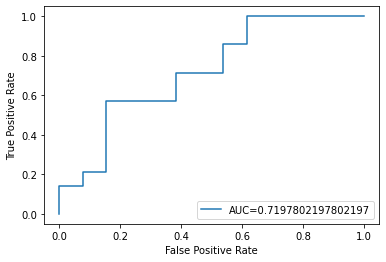

In [171]:
    classes_=[0,1]
    fpr, tpr, _ = skm.roc_curve(y_t2,  pred_agg2)
    auc = skm.roc_auc_score(y_t2,  pred_agg2)
    #create ROC curve
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    print(auc)